# XG Boost Regressor Model - APPL Stock Prediction

In [1]:
!pip install xgboost --quiet

In [21]:
#Importing Libraries
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
%matplotlib inline
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Read APPL.csv contains open, high, low, close, Adj close, Volume of Apple stock with twitter polarity scores and twitter volume
df = pd.read_csv('AAPL.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

# Drop null values
df.dropna(inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
Date,,,,,,,,
2019-08-26,51.47,51.80,51.26,51.62,51.12,104174400,0.072340,888.0
2019-08-27,51.97,52.14,50.88,51.04,50.54,103493200,0.117541,962.0
2019-08-28,51.03,51.43,50.83,51.38,50.88,63755200,0.061477,895.0
2019-08-29,52.13,52.33,51.67,52.25,51.74,83962000,0.056460,1083.0
2019-08-30,52.54,52.61,51.80,52.19,51.67,84573600,0.106096,1005.0


In [7]:
# Dataframe with Adj close, ts_polarity, twitter_volume of APPL
df = df[["Adj Close", "ts_polarity", "twitter_volume"]]
df.head()

,Adj Close,ts_polarity,twitter_volume
Date,,,
2016-01-04,24.44,0.070389,1133.0
2016-01-05,23.83,0.133635,1430.0
2016-01-06,23.36,0.072042,1949.0
2016-01-07,22.38,0.074369,2289.0
2016-01-08,22.50,0.051595,2235.0


In [8]:
# pct change based on Adj close value
df["Pct_change"] = df["Adj Close"].pct_change()

# Drop null values
df.dropna(inplace = True)
df.head()

,Adj Close,ts_polarity,twitter_volume,Pct_change
Date,,,,
2016-01-05,23.83,0.133635,1430.0,-0.024959
2016-01-06,23.36,0.072042,1949.0,-0.019723
2016-01-07,22.38,0.074369,2289.0,-0.041952
2016-01-08,22.50,0.051595,2235.0,0.005362
2016-01-11,22.86,0.019443,1222.0,0.016000


### Creating the Features `X` and Target `y` Data

The first step towards preparing the data was to create the input features `X` and the target vector `y`. We used the `window_data()` function to create these vectors.

This function chunks the data up with a rolling window of _X<sub>t</sub> - window_ to predict _X<sub>t</sub>_.

The function returns two `numpy` arrays:

* `X`: The input features vectors.

* `y`: The target vector.

The function has the following parameters:

* `df`: The original DataFrame with the time series data.

* `window`: The window size in days of previous closing prices that will be used for the prediction.

* `feature_col_number`: The column number from the original DataFrame where the features are located.

* `target_col_number`: The column number from the original DataFrame where the target is located.

In [9]:
# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    # Create empty lists "X_close", "X_polarity", "X_volume" and y
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    for i in range(len(df) - window):

        # Get close, ts_polarity, tw_vol, and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]

        # Append values in the lists
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)

    return np.hstack((X_close,X_polarity,X_volume)), np.array(y).reshape(-1, 1)

In [10]:
# Predict Closing Prices using a 3 day window of previous closing prices
window_size = 3

# Column index 0 is the `Adj Close` column
# Column index 1 is the `ts_polarity` column
# Column index 2 is the `twitter_volume` column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

In [11]:
# Use 70% of the data for training and 30% for testing
X_split = int(0.7 * len(X))
y_split = int(0.7 * len(y))

# Set X_train, X_test, y_train, t_test
X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

# Scaling Data with `MinMaxScaler`

We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.
Note that we scale both features and target sets.

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [14]:
# Create the XG Boost regressor instance
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [15]:
# Fit the model
model.fit(X_train, y_train.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

---

---

## Model Performance

In this section, we will evaluate the model using the test data.

We will:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values.
4. Plot the Real vs predicted values as a line chart


In [16]:
# Make some predictions
predicted = model.predict(X_test)

In [17]:
# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.04766297161947317
R-squared : 0.9591504900093728


In [18]:
# Recover the original prices instead of the scaled version
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [19]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
Date,,
2018-07-27,46.39,47.278915
2018-07-30,46.13,45.850224
2018-07-31,46.22,46.335148
2018-08-01,48.95,45.902985
2018-08-02,50.38,48.946964


<Axes: xlabel='Date'>

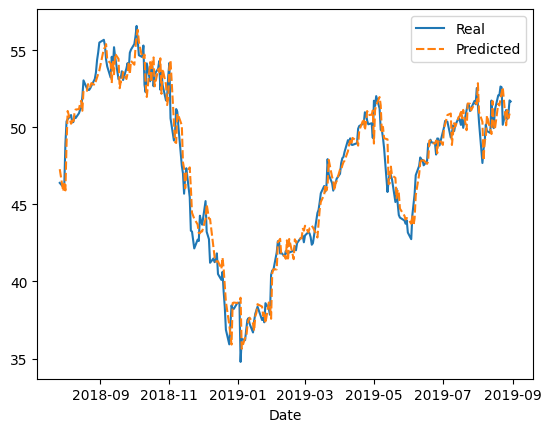

In [23]:
# Plot the real vs predicted values as a line chart
#stocks.hvplot(title = "Real vs Predicted values of APPL")
sns.lineplot(data=stocks)